In [1]:
#Import tensorflow and keras library
import tensorflow as tf
import keras_preprocessing
from tensorflow.keras.preprocessing import image
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.callbacks import ModelCheckpoint

print("[INFO]: Tensorflow version{}".format(tf.__version__))
state_gpu = tf.test.gpu_device_name()
print("[INFO]: GPU usage{0}".format(state_gpu))

[INFO]: Tensorflow version2.9.2
[INFO]: GPU usage/device:GPU:0


In [2]:
# Importing the images 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/BTP/Dataset/tomato.zip','r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/BTP/Dataset/dataset')

In [10]:
train_datagen=ImageDataGenerator(validation_split=0.2,rescale=1./255,
                                 horizontal_flip=True,rotation_range=.2,shear_range=.2)
test_datagen=ImageDataGenerator(rescale=1./255)

In [11]:
TRAINING_DIR = '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/' 
TESTING_DIR = '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/valid/'

In [12]:
training_set=train_datagen.flow_from_directory(TRAINING_DIR,
                                               target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=True,subset="training")

validation_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        subset="validation")

test_set=test_datagen.flow_from_directory(TESTING_DIR,
                                          target_size=(224,224),batch_size=32,class_mode="categorical",shuffle=True)

Found 14678 images belonging to 10 classes.
Found 3667 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [13]:
# TARGET_SIZE = (150,150)
# # TRAIN_BATCH_SIZE = 128
# # VALID_BATCH_SIZE = 32
# SEED = 42

# #Data Iterator
# train_data = train_gen.flow_from_directory(
# TRAINING_DIR,
# target_size = TARGET_SIZE,
# class_mode = 'categorical',
# color_mode = "rgb",
# batch_size = 32,
# shuffle = True,
# seed = SEED,
# subset="training"
# )

# validation_generator = train_gen.flow_from_directory(
#         TRAINING_DIR,
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='categorical',
#         shuffle=True,
#         subset="validation")


# test_data = valid_gen.flow_from_directory(

# TESTING_DIR,
# target_size = TARGET_SIZE,
# class_mode = 'categorical',
# color_mode = "rgb",
# batch_size = 32
# )

In [14]:
from glob import glob
folder=glob("/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/*")
folder

['/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Bacterial_spot',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Early_blight',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Late_blight',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Leaf_Mold',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Septoria_leaf_spot',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Spider_mites Two-spotted_spider_mite',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Target_Spot',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Plant Diseases Dataset(Augmented)/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 '/content/drive/MyDrive/BTP/Dataset/dataset/New Pla

In [15]:
from tensorflow import keras
from keras.applications.vgg16 import VGG16
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[224, 224, 3])
#load weight from local file which is just added
#base_model = applications.VGG16(weights='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(img_rows, img_cols, img_channel))

base_model_weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
# base_model = VGG16(weights=base_model_weights_path, include_top=False, input_shape=(224, 224, 3))

x = keras.layers.Flatten() (base_model.output)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x)
output = keras.layers.Dense(units=len(folder), activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# The newly added layers are initialized with random values.
# Make sure based model remain unchanged until newly added layers weights get reasonable values.
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
LEARNING_RATE = 0.0001
#LEARNING_RATE = 0.001

#Optimizer
opt = Adam(lr = LEARNING_RATE)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
#TRAINING_NUM = train_data.n #or train_data.samples
# VALID_NUM = test_data.n
EPOCHS = 50

# STEP_SIZE_TRAIN = TRAINING_NUM // TRAIN_BATCH_SIZE 
# STEP_SIZE_VALID = VALID_NUM // VALID_BATCH_SIZE

# Fit model to get reasonable weights for newly added layers.
history = model.fit(x = training_set, validation_data=validation_generator,epochs=EPOCHS)

# history = model.fit_generator(train_data,
#                              validation_data = validation_generator,
#                              epochs = EPOCHS)

Epoch 1/50
459/459 [==============================] - 282s 591ms/step - loss: 0.8848 - accuracy: 0.7156 - val_loss: 0.5942 - val_accuracy: 0.8116
Epoch 2/50
 16/459 [>.............................] - ETA: 3:17 - loss: 0.5531 - accuracy: 0.8223

KeyboardInterrupt: ignored

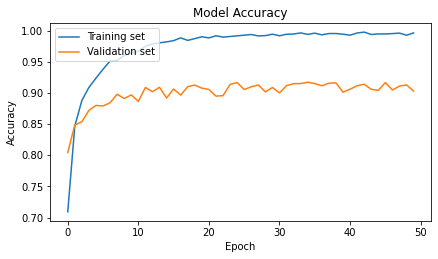

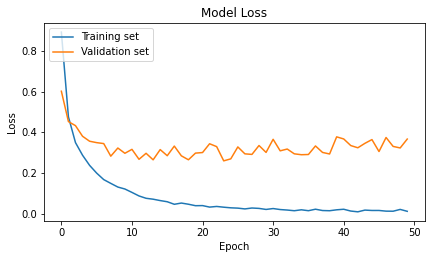

In [ ]:
import matplotlib.pyplot as plt

plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
best_val_acc = max(history.history['val_accuracy'])
print("[INFO] Best Validation Accuracy: %",best_val_acc*100)

[INFO] Best Validation Accuracy: % 91.76438450813293


In [24]:
# Scores is just a list containing loss and accuracy value
scores=model.evaluate(training_set)
scores2=model.evaluate(test_set)
print("Training Loss is : "+str(scores[0]))
print("Training Accuracy is : "+str(scores[1]*100)+" %")
print("Testing Loss is : "+str(scores2[0]))
print("Testing Accuracy is : "+str(scores2[1]*100)+" %")

144/144 [==============================] - 23s 161ms/step - loss: 0.0484 - accuracy: 0.9882
Training Loss is : 0.00015399519179482013
Training Accuracy is : 100.0 %
Testing Loss is : 0.048378780484199524
Testing Accuracy is : 98.82224798202515 %


# FINE-TUNING

In [19]:
for layer in base_model.layers:
    layer.trainable = True

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate (This ensures the base model weights do not change a lot)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [20]:
EPOCHS = 50

# STEP_SIZE_TRAIN = TRAINING_NUM // TRAIN_BATCH_SIZE 
# STEP_SIZE_VALID = VALID_NUM // VALID_BATCH_SIZE

# Fit model to get reasonable weights for newly added layers.
history = model.fit(x = training_set, validation_data=validation_generator,epochs=EPOCHS)


Epoch 1/50
459/459 [==============================] - 311s 665ms/step - loss: 0.3342 - accuracy: 0.8898 - val_loss: 0.2565 - val_accuracy: 0.9149
Epoch 2/50
459/459 [==============================] - 299s 651ms/step - loss: 0.1988 - accuracy: 0.9328 - val_loss: 0.1879 - val_accuracy: 0.9359
Epoch 3/50
459/459 [==============================] - 297s 646ms/step - loss: 0.1335 - accuracy: 0.9547 - val_loss: 0.2084 - val_accuracy: 0.9318
Epoch 4/50
459/459 [==============================] - 291s 634ms/step - loss: 0.1082 - accuracy: 0.9624 - val_loss: 0.1495 - val_accuracy: 0.9476
Epoch 5/50
459/459 [==============================] - 292s 635ms/step - loss: 0.0883 - accuracy: 0.9700 - val_loss: 0.1820 - val_accuracy: 0.9389
Epoch 6/50
459/459 [==============================] - 289s 630ms/step - loss: 0.0642 - accuracy: 0.9775 - val_loss: 0.1474 - val_accuracy: 0.9490
Epoch 7/50
459/459 [==============================] - 292s 635ms/step - loss: 0.0515 - accuracy: 0.9817 - val_loss: 0.1153 -

In [21]:
best_val_acc = max(history.history['val_accuracy'])
print("[INFO] Best Validation Accuracy: %",best_val_acc*100)

[INFO] Best Validation Accuracy: % 98.30924272537231


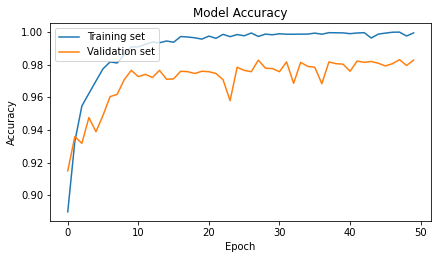

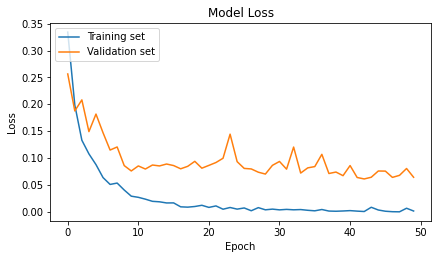

In [22]:
import matplotlib.pyplot as plt

plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [23]:
# Scores is just a list containing loss and accuracy value
scores=model.evaluate(training_set)
scores2=model.evaluate(test_set)
print("Training Loss is : "+str(scores[0]))
print("Training Accuracy is : "+str(scores[1]*100)+" %")
print("Testing Loss is : "+str(scores2[0]))
print("Testing Accuracy is : "+str(scores2[1]*100)+" %")

144/144 [==============================] - 25s 170ms/step - loss: 0.0484 - accuracy: 0.9882
Training Loss is : 0.00017659775039646775
Training Accuracy is : 100.0 %
Testing Loss is : 0.048378780484199524
Testing Accuracy is : 98.82224798202515 %
